In [18]:
%matplotlib inline
from matplotlib import style
# https://matplotlib.org/stable/gallery/style_sheets/fivethirtyeight.html
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [19]:
import numpy as np
import pandas as pd

In [20]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [21]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [25]:
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [26]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [27]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [29]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [30]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

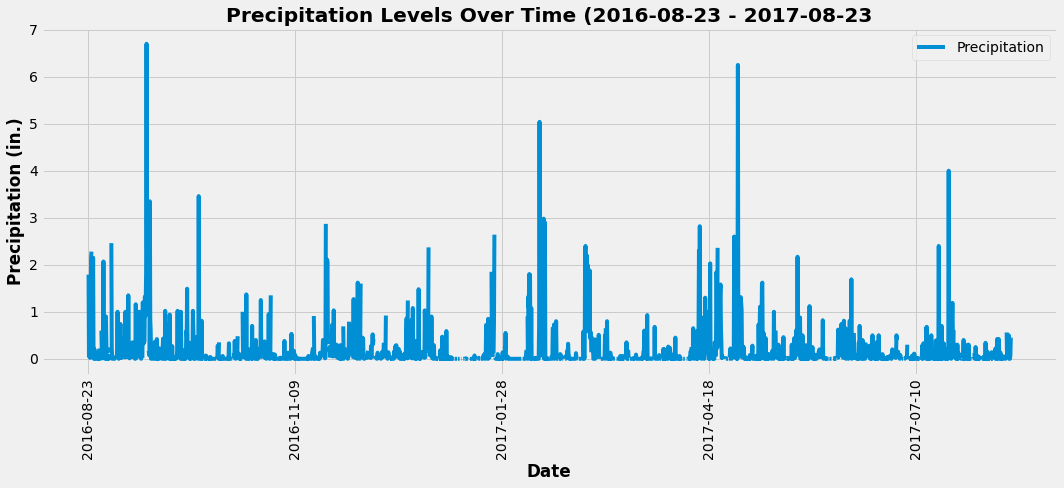

In [68]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Latest date in measurement table is 2017-08-23
# https://stackoverflow.com/questions/32334312/subtracting-n-days-from-date-in-python

# Calculate the date 1 year ago from the last data point in the database
year_minus_365 = dt.date(2017,8,23) - dt.timedelta(days=365)
latest_year = dt.date(2017,8,23)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_minus_365).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
results_df = pd.DataFrame(results, columns = ['Date','Precipitation'])
results_df.set_index(results_df['Date'], inplace = True)
# results_df - check = OK

# Sort the dataframe by date
results_df = results_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
fig_1 = results_df.plot(rot = 90, figsize = (15,7), x_compat = True, zorder = 3)
fig_1.set_xlabel("Date", fontweight = 'bold')
fig_1.set_ylabel("Precipitation (in.)", fontweight = 'bold')
fig_1.set_title(f"Precipitation Levels Over Time ({year_minus_365} - {latest_year}", fontweight = 'bold')
fig_1.grid(zorder = 0)
plt.tight_layout()
plt.savefig('../Images/Precipitation Levels Over Time.png')
plt.show()

In [70]:
# Use Pandas to calcualte the summary statistics for the precipitation data
results_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [76]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).count()
print(f"There are {station_count} stations in this dataset")

There are 9 stations in this dataset


In [77]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station, func.count(Measurement.id)]
most_active_stations = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [89]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
# define sel as the variables needed and filter by first result in most_active_stations
sel = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
most_active_station_data = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).first()
most_active_station_data
print(f"The most active station was {(most_active_stations[0])[0]}.\
    \nThe minimum teperature recorded was {most_active_station_data[0]}.\
    \nThe maximum temperature recorded was {most_active_station_data[1]}.\
    \nThe average temperature recorded was {most_active_station_data[2] : ,.1f}")

The most active station was USC00519281.    
The minimum teperature recorded was 54.0.    
The maximum temperature recorded was 85.0.    
The average temperature recorded was  71.7


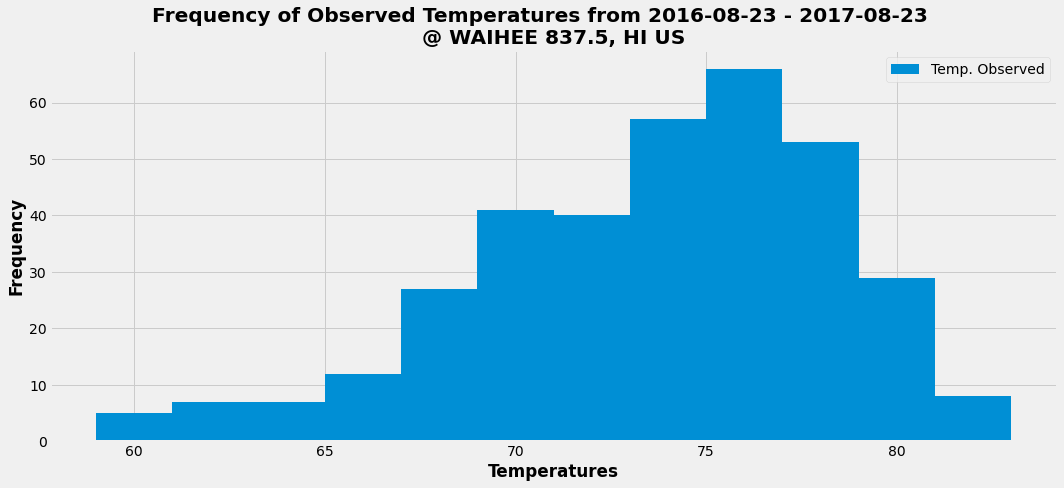

In [112]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
ss_result = session.query(Measurement.tobs).filter(Measurement.station == most_active_stations[0][0]).filter(Measurement.date >= year_minus_365).all()
temperatures = list(np.ravel(ss_result))
# len(temperatures)

# Place station table into a DF.
sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
queryresult = session.query(*sel).all()
stations_desc = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation'])
# use .loc on DF to return row which matches most_active_stations query result
stationname = stations_desc.loc[stations_desc["Station"] == most_active_stations[0][0],"Name"].tolist()[0]
# stationname returns the correct result from prior cell.
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize = (15,7))
plt.hist(temperatures, bins = 12, rwidth = 15, label = "Temp. Observed")
plt.ylabel("Frequency", fontweight = 'bold')
plt.xlabel("Temperatures", fontweight = 'bold')
plt.title(f"Frequency of Observed Temperatures from {year_minus_365} - {latest_year}\
    \n@ {stationname}", fontweight = 'bold')
plt.grid(zorder = 0)
plt.legend()
plt.tight_layout()
plt.savefig('../Images/Frequency of Observed Temperatures @ Most Active Station.png')
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
